# Covid-19 X-Ray Image Classification using ResNet-50 Model
 

# student details
### name: Satyanarayan Vadapalli
### email: svadapal@uwo.ca

## Importing needed libraries


In [115]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [116]:
import tensorflow as tf
from tensorflow.python.client import device_lib
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report,precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns 
import math
import pickle  
from prettytable import PrettyTable
import zipfile

# Checking the GPU version and Tensorflow Version 


In [ ]:
# checking if running on GPU or Not
# if it's blank that means no device is gpu is connected, change to hosted 
# run time
print(f"tensorflow version: {tf.__version__}")

# checking for a gpu, code adapted from colab pro website
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

tensorflow version: 2.8.0
Wed Apr 13 15:58:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

In [ ]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2802041108951705477
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5723941598970216169
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

## Dataset Loading

Downloading the dataset using the CURL command

In [ ]:
#saving the file to /content/drive/MyDrive/ML-DATA/COVID19_DATASET.zip
# wget usage reference: https://www.gnu.org/software/wget/manual/wget.html
!wget -O /content/drive/MyDrive/ML-DATA//COVID19_DATASET.zip https://machinelearningdata.nyc3.digitaloceanspaces.com/COVID-19__X-RAY__DATASET.zip

--2022-03-21 05:33:31--  https://machinelearningdata.nyc3.digitaloceanspaces.com/COVID-19__X-RAY__DATASET.zip
Resolving machinelearningdata.nyc3.digitaloceanspaces.com (machinelearningdata.nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to machinelearningdata.nyc3.digitaloceanspaces.com (machinelearningdata.nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2206923930 (2.1G) [application/x-zip-compressed]
Saving to: ‘./COVID19_DATASET.zip’

./COVID19_DATASET.z 100%[===================>]   2.05G  59.2MB/s    in 32s     

2022-03-21 05:34:03 (65.6 MB/s) - ‘./COVID19_DATASET.zip’ saved [2206923930/2206923930]



# Unzipping the Zip file

In [ ]:
# Unzip data in the newly created directory. Run only once
with zipfile.ZipFile("/content/drive/MyDrive/ML-DATA/COVID19_DATASET.zip", "r") as zip_fp:
    zip_fp.extractall("/content/drive/MyDrive/ML-DATA/COVID19_DATASET/")

In [117]:
# Dataset directories; run only once
dir_covid = '/content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT'

dir_test = os.path.join(dir_covid,'test')
dir_train = os.path.join(dir_covid,'train')
dir_validation = os.path.join(dir_covid,'validation')

## Displaying Examples 


In [ ]:
# code adapted from the link: https://www.positronx.io/python-count-the-number-of-files-and-directories/
# Displaying the directory structure
totalFiles = 0
totalDir = 0
for base, dirs, files in os.walk(dir_covid):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1
print("\n\n")
print('Total number of files',totalFiles)
print('Total Number of directories',totalDir)
print('Total:',(totalDir + totalFiles))

Searching in :  /content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT
Searching in :  /content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT/test
Searching in :  /content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT/test/COVID19
Searching in :  /content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT/test/NORMAL
Searching in :  /content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT/test/PNEUMONIA
Searching in :  /content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT/train
Searching in :  /content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT/train/COVID19
Searching in :  /content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT/train/NORMAL
Searching in :  /content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT/train/PNEUMONIA
Searching in :  /content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT/validation
Searching in :  /content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT/validation/COVID19
Searching in :  /content/drive/MyDrive/ML-DATA/COVID19_DATASET

Plotting the images present in the folder


Text(0.5, 1.0, 'Pneumonia Lung')

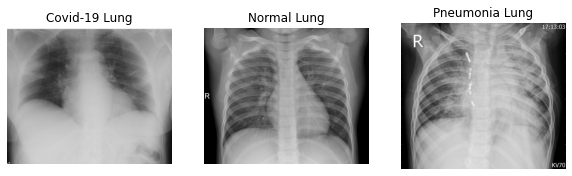

In [ ]:
#Code adapted from https://www.geeksforgeeks.org/how-to-display-multiple-images-in-one-figure-correctly-in-matplotlib/
# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 1
columns = 3
  
# reading images
Image1 = cv2.imread('/content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT/train/COVID19/COVID19(114).jpg')
Image2 = cv2.imread('/content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT/train/NORMAL/NORMAL(1000).jpg')
Image3 = cv2.imread('/content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT/train/PNEUMONIA/PNEUMONIA(1000).jpg')
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("Covid-19 Lung")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Normal Lung")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Pneumonia Lung")

## Dataset Exploration


In [118]:
# simple version for working with CWD

test_covid19_img_count = len([name for name in os.listdir('/content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT/test/COVID19')])
test_normal_img_count = len([name for name in os.listdir('/content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT/test/NORMAL')])
test_penumonia_img_count = len([name for name in os.listdir('/content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT/test/PNEUMONIA')])

train_covid19_img_count = len([name for name in os.listdir('/content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT/train/COVID19')])
train_normal_img_count = len([name for name in os.listdir('/content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT/train/NORMAL')])
train_penumonia_img_count = len([name for name in os.listdir('/content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT/train/PNEUMONIA')])

valid_covid19_img_count = len([name for name in os.listdir('/content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT/validation/COVID19')])
valid_normal_img_count = len([name for name in os.listdir('/content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT/validation/NORMAL')])
valid_penumonia_img_count = len([name for name in os.listdir('/content/drive/MyDrive/ML-DATA/COVID19_DATASET/COVID19_DT/validation/PNEUMONIA')])

total_covid19_img_covid = test_covid19_img_count + train_covid19_img_count + valid_covid19_img_count
total_normal_img_covid = test_normal_img_count + train_normal_img_count + valid_normal_img_count
total_penumonia_img_covid = test_penumonia_img_count + train_penumonia_img_count + valid_penumonia_img_count

print(f'Total number of covid, normal and penumonia images are: {[total_covid19_img_covid, total_normal_img_covid, total_penumonia_img_covid]}')


Total number of covid, normal and penumonia images are: [576, 1583, 4273]


Text(0.5, 1.0, "Image's distribution in the dataset ")

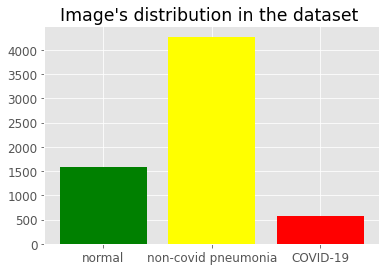

In [119]:
colors = ['green', 'yellow', 'red']
labels=["normal", "non-covid pneumonia", "COVID-19"]

plt.bar(labels, [total_normal_img_covid, total_penumonia_img_covid, total_covid19_img_covid], color=colors)
plt.title("Image's distribution in the dataset ")

Addressing weight imbalance

In [120]:
# understood class weights: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
# one more link: https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
# one more link: https://towardsdatascience.com/dealing-with-imbalanced-data-in-tensorflow-class-weights-60f876911f99
 
# all_images = 6432
all_images = total_covid19_img_covid + total_normal_img_covid + total_penumonia_img_covid

# covid_dataset_weight = 3.7222
covid_dataset_weight = (all_images/3)*(1/total_covid19_img_covid)

# pneumonia_dataset_weight = 0.5017
pneumonia_dataset_weight = (all_images/3)*(1/total_penumonia_img_covid)

#nomarl_dataset_weight = 1.3544
normal_dataset_weight = (all_images/3)*(1/total_normal_img_covid)


In [121]:
# a dictonary of weights
# class imbalance addressed here and adapted to suite our use case: https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
# class imbalance api reference: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights

weights_dictionary = { 0:covid_dataset_weight, 1:normal_dataset_weight, 2:pneumonia_dataset_weight}

## Prepare the data for training

In [122]:
#resizing and generation of training images
# API Reference: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
batch = 64
image_size = (224, 224)

# gen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale = rescale) # this parameter has increased the training time a lot, removing this improved the training time and accuracy of the model
gen_train = tf.keras.preprocessing.image.ImageDataGenerator()
train_data_gen = gen_train.flow_from_directory( dir_train, 
                                               target_size = image_size, 
                                               batch_size=batch, 
                                               shuffle=True)


Found 3860 images belonging to 3 classes.


In [123]:
#resizing and generation of testing images
# API Reference: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
batch = 64
image_size = (224, 224)
# rescale_param = 1./255

gen_test = tf.keras.preprocessing.image.ImageDataGenerator()
test_data_gen = gen_test.flow_from_directory(dir_test, 
                                             target_size = image_size, 
                                             batch_size=batch, shuffle=True )


Found 1285 images belonging to 3 classes.


In [124]:
#resizing and generation of validation images
# API Reference: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
batch = 64
image_size = (224, 224)
# rescale_param = 1./255

gen_val = tf.keras.preprocessing.image.ImageDataGenerator()
val_data_gen = gen_val.flow_from_directory(dir_validation, 
                                           target_size = image_size, 
                                           batch_size = batch, 
                                           shuffle = True )

Found 1287 images belonging to 3 classes.


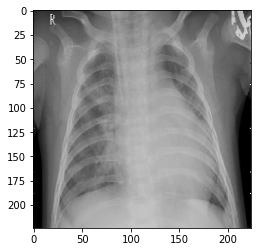

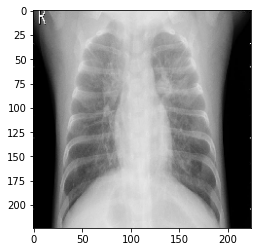

In [ ]:
# Code adapated to the use case from: https://stackoverflow.com/questions/59217031/plot-images-from-image-generator
# API reference: https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.imshow.html
# Run once
x= (next(train_data_gen)[0])/255.0
for i in range(0,2):
    image = x[i]
    plt.imshow(image)
    plt.show()

In [125]:
#the indices of classes
print(f'the classes and their repective indices are: {train_data_gen.class_indices}')

the classes and their repective indices are: {'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


## Model Creation

### Load Resnet50  

Building the Base model

In [126]:
# Code adapted from the API Reference example at: https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50
resnet50 = tf.keras.applications.ResNet50( 
    include_top = False, 
    input_shape = (224, 224, 3), 
    weights = None)

# Degraded performance if the imagenet weights are used, hence not using those during the intial phases of training
# resnet50 = tf.keras.applications.ResNet50( include_top=False, 
                                          # input_shape=(224, 224, 3), 
                                          # weights="imagenet")

In [127]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [93]:
# excluding the added custom layers
resnet50.output

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

### Covid Resnet50 model construction
Adding a few custom layers to resnet50 in the end to enhance the model performance

In [128]:
def make_base_model(base_model):
      # Code adapted from API Reference for input function https://www.tensorflow.org/api_docs/python/tf/keras/Input
      input_given = tf.keras.Input(shape=(224,224,3))
      preprocess_inp = tf.keras.applications.resnet.preprocess_input(input_given)
      model_base = base_model(preprocess_inp)
      # for layer in model_base.layers: # degrades the model performance, hence not freezing the layers
      #   layer.trainable = False or could also use the undermentioned 
      # model_base.trainable = False not using this cause it degrades the model performance
      # Code adapted from API Reference: https://www.tensorflow.org/api_docs/python/tf/keras/layers
      global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(model_base)
      first_drop_out = tf.keras.layers.Dropout(0.4)(global_average_layer)
      dense_layer = tf.keras.layers.Dense(4096, activation='relu')(first_drop_out)
      second_drop_out = tf.keras.layers.Dropout(0.4)(dense_layer)
      # since the output layer has 3 class, hence creating the final dense layer with 3 neurons
      output_model = tf.keras.layers.Dense(3, activation='softmax')(second_drop_out)

      # Created Model Returned
      # Code adapted from API Reference: https://www.tensorflow.org/api_docs/python/tf/keras/Model
      model=tf.keras.models.Model( inputs=input_given, 
                                  outputs=output_model)

      return model


In [129]:
final_model = make_base_model(resnet50)

In [130]:
final_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

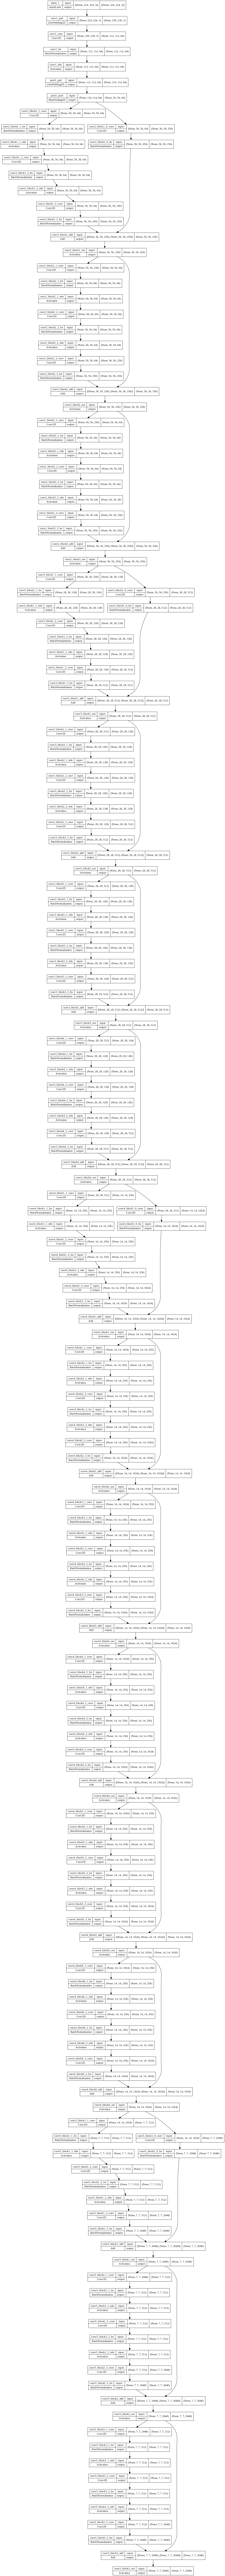

In [17]:
# Code adapted from :-> https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model 
# Run once
tf.keras.utils.plot_model(resnet50, 
                          show_shapes=True, 
                          to_file='/content/drive/MyDrive/ML-DATA/model/base-model-resnet-50.png', 
                          dpi=120)

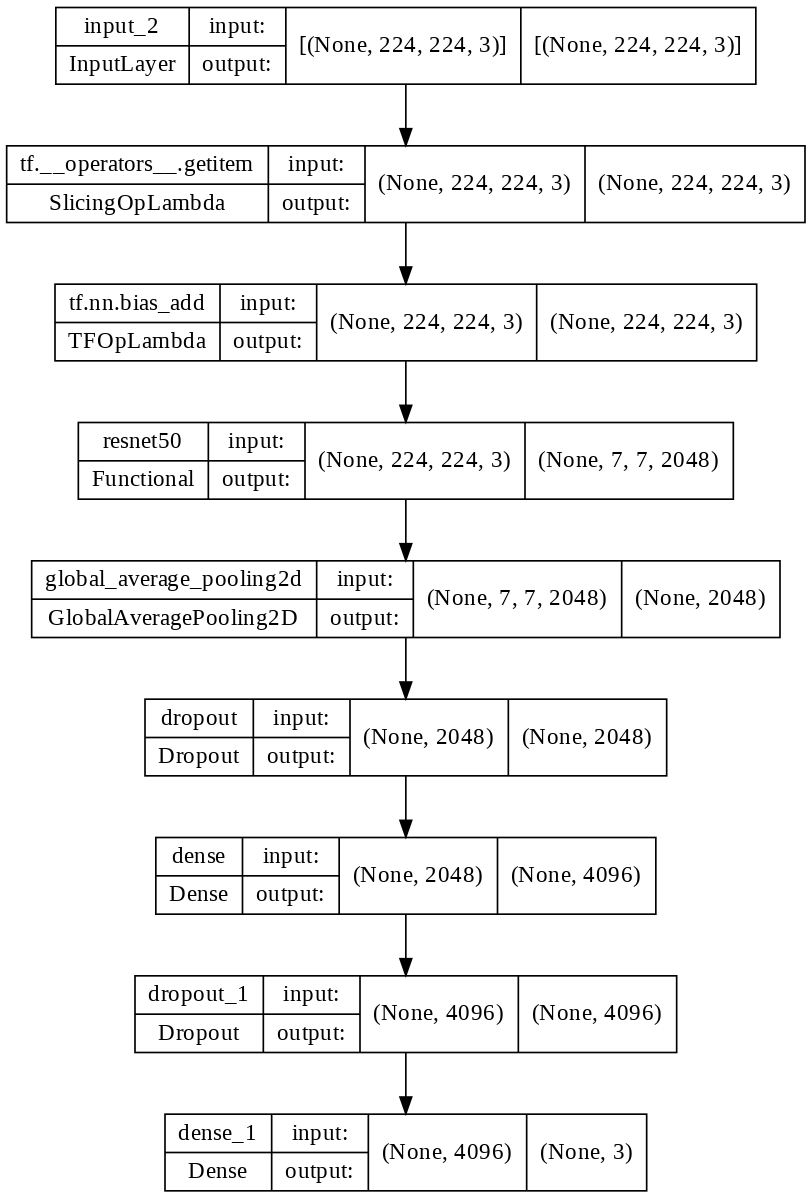

In [ ]:
# Code adapted from :-> https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model 
# Run once
tf.keras.utils.plot_model(final_model, 
                          show_shapes=True, 
                          to_file='/content/drive/MyDrive/ML-DATA/model/final_model.png',
                          dpi=120)

In [131]:
#Number of total CovidResnet layers
#Number of layers in Resnet50
no_of_layers_base_model = len(resnet50.layers)
print(f'Total number of layers in the base model: {no_of_layers_base_model}')
print(f'Total number of layers in the final model:{len(final_model.layers) + no_of_layers_base_model-1}')

Total number of layers in the base model: 175
Total number of layers in the final model:183


### Regularization



In [19]:
# creating the model and checkpoints directory
# run only once
!mkdir /content/drive/MyDrive/ML-DATA/model/
!mkdir -p /content/drive/MyDrive/ML-DATA/model/checkpoints

mkdir: cannot create directory ‘/content/drive/MyDrive/ML-DATA/model/’: File exists


In [132]:
checkpoints_dir = r'/content/drive/MyDrive/ML-DATA/model/checkpoints'

In [133]:
#saving checkpoints after each epoch
def make_checkpoint(path, checkpoints_dir, save_frequency='epoch'):
      
      path_check = os.path.join(checkpoints_dir, path)
      path_dir=os.path.dirname(path_check)
      
      # Code adapted from :-> API Reference: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
      # creating continuous checkpoints after each epoch
      checkpoint=tf.keras.callbacks.ModelCheckpoint( filepath=path_check, 
                                                    save_freq=save_frequency, 
                                                    save_weights_only=True, 
                                                    save_best_only=True, 
                                                    monitor='val_accuracy')
      
      return checkpoint, path_dir

In [134]:
#making checkpoints after the best epoch, passing this as an argument to the fit function as callback
path_checkpoint_train = 'training-3/RESNET50_weights.{epoch:04d}.hdf5'
dir_checkpoint_train=os.path.dirname(path_checkpoint_train)
# Calling the method from imp_func class, checkpoint creation reference provided in the method
checkpoint, dir_ckpt = make_checkpoint(path_checkpoint_train, checkpoints_dir) # making checkpoints after each epoch, as a way of regularization. 

In [100]:
#callback to reduce the learning rate when the validation loss set stagnates
# API Reference: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
learn_rate_reduce = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.7, patience = 3)

In [101]:
# using early stopping if there's no improvement in the loss for 3 consecutive epochs
# Code adapted from :-> https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                         patience=3)

### Compile model

In [136]:
init_learning_rate = 0.001
#instantiating Adam optimizer
# API Reference: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
optimizer = tf.keras.optimizers.Adam(learning_rate = init_learning_rate)

# Compiling the final model 
final_model.compile(optimizer=optimizer, 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

## Train the model

In [ ]:
# load only if the model fitting is interrupted, loading the weights from previous session, as the training was interrupted because of usage limits of google colab
# Run once
# model_checkpoint_path = r'/content/drive/MyDrive/ML-DATA/model/checkpoints/training-2/Model1_weights.0028.hdf5'
# final_model.load_weights(model_checkpoint_path)

In [137]:
history = final_model.fit( x = train_data_gen, 
                          validation_data = val_data_gen, 
                          epochs = 40, 
                          callbacks = [learn_rate_reduce, earlyStoppingCallback, checkpoint], 
                          class_weight = weights_dictionary)

Epoch 1/40
61/61 [==============================] - 146s 2s/step - loss: 2.8811 - accuracy: 0.3702 - val_loss: 1.8933 - val_accuracy: 0.1950 - lr: 0.0010
Epoch 2/40
61/61 [==============================] - 122s 2s/step - loss: 0.7341 - accuracy: 0.6487 - val_loss: 0.9218 - val_accuracy: 0.6713 - lr: 0.0010
Epoch 3/40
61/61 [==============================] - 135s 2s/step - loss: 0.5185 - accuracy: 0.7733 - val_loss: 24.9708 - val_accuracy: 0.6713 - lr: 0.0010
Epoch 4/40
61/61 [==============================] - 121s 2s/step - loss: 0.3494 - accuracy: 0.8420 - val_loss: 1.5126 - val_accuracy: 0.6775 - lr: 0.0010
Epoch 5/40
61/61 [==============================] - 122s 2s/step - loss: 0.3205 - accuracy: 0.8666 - val_loss: 1.1919 - val_accuracy: 0.4118 - lr: 0.0010
Epoch 6/40
61/61 [==============================] - 121s 2s/step - loss: 0.2574 - accuracy: 0.8821 - val_loss: 0.5547 - val_accuracy: 0.8050 - lr: 7.0000e-04
Epoch 7/40
61/61 [==============================] - 122s 2s/step - loss

## Plot Evaluation Metrics

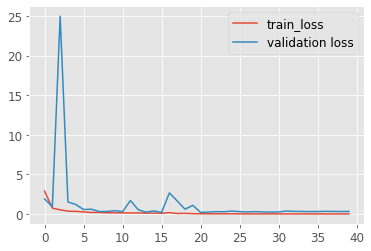

In [138]:
# Code adapted from :-> https://www.kaggle.com/code/dskagglemt/car-image-classification-using-resnet50/notebook
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()
plt.show()

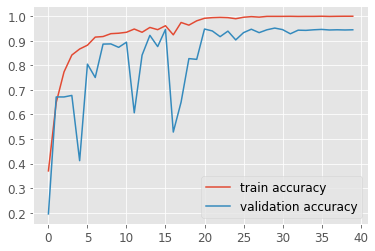

In [139]:
# Code adapted from :-> https://www.kaggle.com/code/dskagglemt/car-image-classification-using-resnet50/notebook
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['val_accuracy'], label ='validation accuracy')
plt.legend()
plt.show()

In [140]:
# code adapted from source: https://www.kaggle.com/code/shub20/lung-image-classification-97-acc
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(40)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

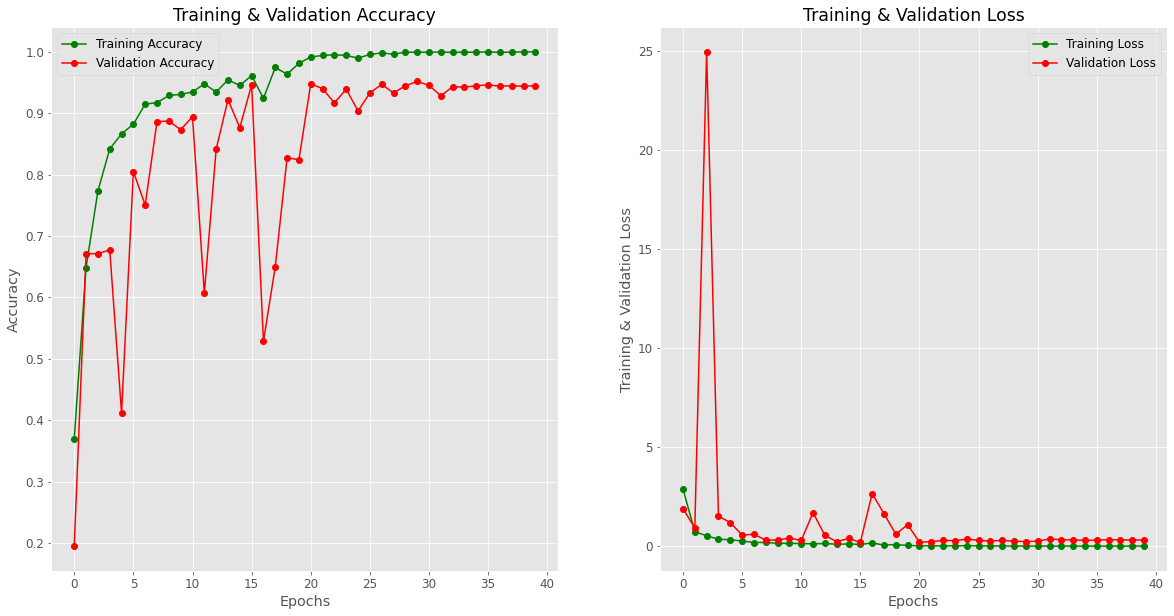

In [141]:
plot_accuracy_loss_chart(history)

In [143]:
# dumping the data of history object into a pickle file :-> https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object
# Easy to load the metrics at a later point in time, in case if google colab times out

hist_dir = r'/content/drive/MyDrive/ML-DATA/model/history.pkl'
with open(hist_dir, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


### Model restoration

In [144]:
history = pickle.load(open(hist_dir,'rb'))

In [146]:
# manually adding the best checkpoint, to do it in code, we need to write a custom call back function, due to time constrains we're choosing this path
get_best_checkpoint = r'/content/drive/MyDrive/ML-DATA/model/checkpoints/training-3/RESNET50_weights.0030.hdf5'

In [147]:
#create new model instance
covid_resnet_restored = make_base_model(resnet50)

In [148]:
#compile the model
covid_resnet_restored.compile( optimizer=optimizer, 
                              loss='categorical_crossentropy', 
                              metrics=['accuracy'])

In [149]:
#Load the weights for the model
covid_resnet_restored.load_weights(get_best_checkpoint)

In [150]:
covid_resnet_restored.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

## Testing the model

In [151]:
test_loss = covid_resnet_restored.evaluate(test_data_gen)

21/21 [==============================] - 32s 1s/step - loss: 0.2637 - accuracy: 0.9362


### Confusion Matrix

In [152]:
# code taken source: https://medium.com/@scueval07/covid-resnet-covid-19-detection-in-chest-x-ray-a11a4f72c490
def total_batch(generator):
 
  batches=math.ceil(generator.samples/generator.batch_size)
  
  for batch in range(batches):
    
    if batch==0:
      x,y=next(generator)
    else:
      x_batch,y_batch=next(generator)
      x=np.vstack((x,x_batch))
      y=np.vstack((y,y_batch))

  labels=np.argmax(y,axis=-1)
  class_indices=generator.class_indices
  return x, labels, class_indices

In [153]:
x_test, y_test, class_ind_test = total_batch(test_data_gen)

In [154]:
y_pred_test = np.argmax(covid_resnet_restored.predict(x_test), axis=1)

In [155]:
def plot_confusion_matrix(ytest, ypred, labels):
      # Code adapted from API Reference example to meet our use case: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
      cm = confusion_matrix(ytest ,ypred, labels=labels)
      plt.figure(figsize=(10, 10))
      # Code adapted from API Reference example to meet our use case: https://seaborn.pydata.org/generated/seaborn.heatmap.html
      class_names = ['COVID','NORMAL','VIRAL PNEUMONIA']
      sns.heatmap(cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
      plt.title('Confusion matrix ')
      plt.xlabel('Predictions')
      plt.ylabel('True label')
     

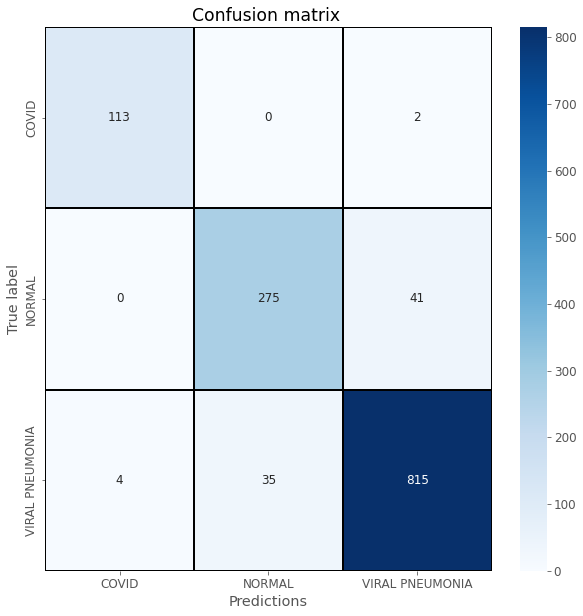

In [156]:
plot_confusion_matrix(y_test, y_pred_test, labels = [0,1,2])

In [157]:
# Code adapted from API Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
print(classification_report( y_test, y_pred_test, target_names=["covid-19","normal",'pneumonia']))

              precision    recall  f1-score   support

    covid-19       0.97      0.98      0.97       115
      normal       0.89      0.87      0.88       316
   pneumonia       0.95      0.95      0.95       854

    accuracy                           0.94      1285
   macro avg       0.93      0.94      0.93      1285
weighted avg       0.94      0.94      0.94      1285



# Conclusion

The model accuracy is 94% and f-score is 94%

### Dataset link: https://www.kaggle.com/prashant268/chest-xray-covid19-pneumonia